In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

from os import listdir
from os.path import isfile, join

import pandas as pd

from PIL import Image
import cv2

from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGES_SIZE = (180,180)

In [3]:
def getActiveNeuron(gender):
    if gender == 'male':
        return np.array([1, 0])
    else:
        return np.array([0, 1])
    
def generateDataset(imagesize=IMAGES_SIZE, percent_sampling=0.1):
    # Generating dataset:

    datasetbase_path = './hands_dataset/'
    datasetless_path = './lessDataset_bregy/'

    datasetInfo = pd.read_csv('./HandInfo.csv')
    sampleHands = datasetInfo.sample(frac=0.1)

    print "Making little dataset with %i images"%len(sampleHands)

    images_names = []
    for i in xrange(len(sampleHands)):
        iname = sampleHands.iloc[i]['imageName']
        images_names.append(iname)
        img = Image.open(join(datasetbase_path, iname))
        img = img.resize(IMAGES_SIZE)
        img = img.rotate(angle=180)
        img.save(join(datasetless_path, iname))
    
    return sampleHands

In [4]:
def generateTrainingSetFromDir(inputdir='./lessDataset_bregy/', handinfo='./HandInfo.csv'):
    labels_gender = []
    labels_binary = []
    total_images = []
    
    datasetInfo = pd.read_csv(handinfo)
    
    datasetByImageName = datasetInfo.set_index('imageName')
    
    genderToOut = {'male':0, 'female': 1}
    images_from_dir = [f for f in listdir(inputdir) if isfile(join(inputdir, f))]

    for s in images_from_dir:
        if 'Hand' in s:
            namei = s
            image = cv2.imread(join(inputdir, namei))
            total_images.append(image)


            gender = datasetByImageName.loc[namei, 'gender']
            if not 'str' in str(type(gender)):
                labels_gender.append(gender[0])
                labels_binary.append(getActiveNeuron(gender[0]))
            else:
                labels_gender.append(gender)
                labels_binary.append(getActiveNeuron(gender))

    total_images = np.array(total_images)
    labels_binary = np.array(labels_binary)

    labels_bin_one = []
    for g in labels_gender:
        labels_bin_one.append(genderToOut[g])
    labels_bin_one = np.array(labels_bin_one)
   
    return total_images, labels_bin_one, labels_binary

In [5]:
def generateTrainingSetFromSampleDf(dataframe, images_names, datasetless_path):

    labels_gender = []
    labels_binary = []
    total_images = []

    genderToOut = {'male':0, 'female': 1}
    sample_by_name = sampleHands.set_index('imageName')
    for s in range(len(sample_by_name)):

        namei = images_names[s]
        image = cv2.imread(join(datasetless_path, namei))
        total_images.append(image)


        gender = sample_by_name.loc[namei, 'gender']
        if not 'str' in str(type(gender)):
            labels_gender.append(gender[0])
            labels_binary.append(getActiveNeuron(gender[0]))
        else:
            labels_gender.append(gender)
            labels_binary.append(getActiveNeuron(gender))

    total_images = np.array(total_images)
    labels_binary = np.array(labels_binary)

    labels_bin_one = []
    for g in labels_gender:
        labels_bin_one.append(genderToOut[g])
    labels_bin_one = np.array(labels_bin_one)
    
    return total_images, labels_bin_one, labels_binary

In [6]:
imgs, gender, onehot = generateTrainingSetFromDir()
print(imgs.shape) 
print(gender.shape)
print(onehot.shape)

(1108, 180, 180, 3)
(1108,)
(1108, 2)


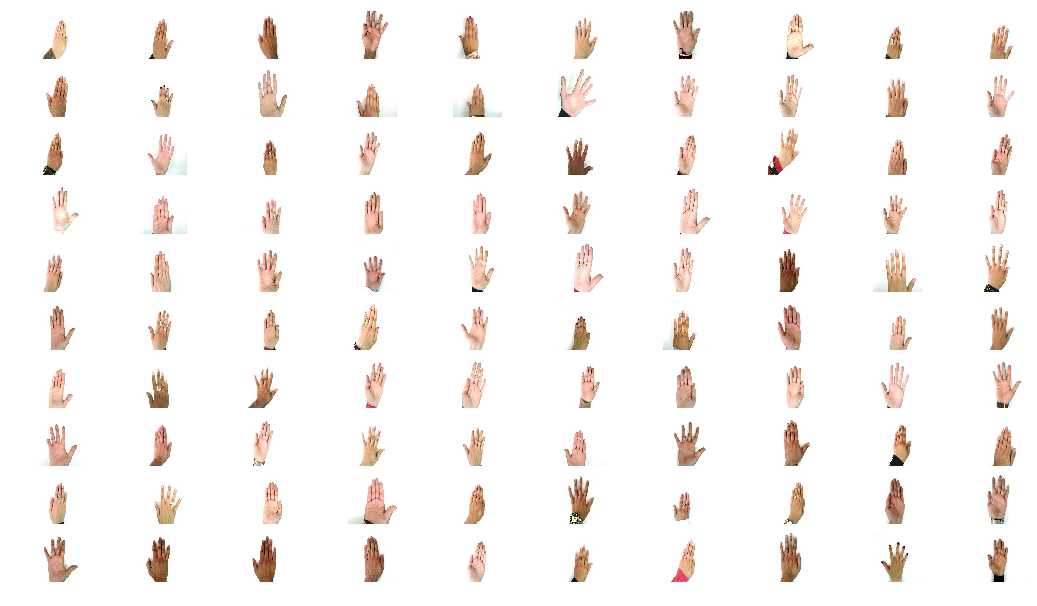

In [7]:
# Plotting firsts hands
f, axarr = plt.subplots(10, 10)
f.set_size_inches(18.5, 10.5)
index = 0
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(imgs[index][...,::-1])
        axarr[i,j].axis('off')
        index += 1

In [12]:
patterns_extract = Sequential()

patterns_extract.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGES_SIZE[0], IMAGES_SIZE[1], 3)))
patterns_extract.add(Conv2D(16, (3, 3), activation='relu'))
patterns_extract.add(MaxPooling2D(pool_size=(2, 2)))
patterns_extract.add(Dropout(0.25))

patterns_extract.add(Conv2D(32, (3, 3), activation='relu'))
patterns_extract.add(Conv2D(32, (3, 3), activation='relu'))
patterns_extract.add(MaxPooling2D(pool_size=(2, 2)))
patterns_extract.add(Dropout(0.25))

patterns_extract.add(Conv2D(64, (3, 3), activation='relu'))
patterns_extract.add(Conv2D(64, (3, 3), activation='relu'))
patterns_extract.add(MaxPooling2D(pool_size=(2, 2)))
patterns_extract.add(Dropout(0.25))

patterns_extract.add(Flatten())

patterns_extract.add(Dense(2000, activation='relu'))
patterns_extract.add(Dropout(0.5))
patterns_extract.add(Dense(1500, activation='relu'))
patterns_extract.add(Dropout(0.5))
patterns_extract.add(Dense(1500, activation='relu'))
patterns_extract.add(Dropout(0.5))
patterns_extract.add(Dense(100, activation='relu'))
patterns_extract.add(Dropout(0.5))

patterns_extract.add(Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
nadam = keras.optimizers.Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

patterns_extract.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

patterns_extract.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 86, 86, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 84, 84, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 32)        0         
__________

In [13]:
hist = patterns_extract.fit(imgs, gender, epochs=300, batch_size=128)

Epoch 1/300
1108/1108 [==============================] - 63s 57ms/step - loss: 6.3996 - acc: 0.5560
Epoch 2/300
1108/1108 [==============================] - 63s 57ms/step - loss: 6.2707 - acc: 0.5569
Epoch 3/300
1108/1108 [==============================] - 62s 56ms/step - loss: 5.7444 - acc: 0.5830
Epoch 4/300
1108/1108 [==============================] - 63s 56ms/step - loss: 5.6674 - acc: 0.5921
Epoch 5/300
1108/1108 [==============================] - 63s 57ms/step - loss: 5.4618 - acc: 0.6182
Epoch 6/300
1108/1108 [==============================] - 63s 57ms/step - loss: 5.5860 - acc: 0.6110
Epoch 7/300
1108/1108 [==============================] - 62s 56ms/step - loss: 5.3067 - acc: 0.6318
Epoch 8/300
1108/1108 [==============================] - 63s 56ms/step - loss: 5.3555 - acc: 0.6227
Epoch 9/300
1108/1108 [==============================] - 63s 57ms/step - loss: 5.2991 - acc: 0.6236
Epoch 10/300
1108/1108 [==============================] - 63s 57ms/step - loss: 5.0878 - acc: 0.6119

1108/1108 [==============================] - 61s 55ms/step - loss: 0.6673 - acc: 0.5957
Epoch 83/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6815 - acc: 0.5623
Epoch 84/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6766 - acc: 0.5939
Epoch 85/300
1108/1108 [==============================] - 61s 55ms/step - loss: 0.6804 - acc: 0.5776
Epoch 86/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6886 - acc: 0.5894
Epoch 87/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6808 - acc: 0.5767
Epoch 88/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6730 - acc: 0.5939
Epoch 89/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6682 - acc: 0.5957
Epoch 90/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6701 - acc: 0.5812
Epoch 91/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6858 - acc: 0.5740
Epo

1108/1108 [==============================] - 61s 55ms/step - loss: 0.6543 - acc: 0.6038
Epoch 163/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6462 - acc: 0.6191
Epoch 164/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6553 - acc: 0.6155
Epoch 165/300
1108/1108 [==============================] - 61s 55ms/step - loss: 0.6580 - acc: 0.6200
Epoch 166/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6459 - acc: 0.6092
Epoch 167/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6571 - acc: 0.6137
Epoch 168/300
1108/1108 [==============================] - 61s 55ms/step - loss: 0.6539 - acc: 0.6164
Epoch 169/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6673 - acc: 0.6083
Epoch 170/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6607 - acc: 0.6110
Epoch 171/300
1108/1108 [==============================] - 61s 55ms/step - loss: 0.6491 - acc: 0

1108/1108 [==============================] - 63s 57ms/step - loss: 0.6481 - acc: 0.6200
Epoch 243/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6498 - acc: 0.6218
Epoch 244/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6642 - acc: 0.6056
Epoch 245/300
1108/1108 [==============================] - 63s 56ms/step - loss: 0.6453 - acc: 0.6309
Epoch 246/300
1108/1108 [==============================] - 63s 57ms/step - loss: 0.6397 - acc: 0.6282
Epoch 247/300
1108/1108 [==============================] - 63s 56ms/step - loss: 0.6451 - acc: 0.6282
Epoch 248/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6372 - acc: 0.6534
Epoch 249/300
1108/1108 [==============================] - 62s 56ms/step - loss: 0.6503 - acc: 0.6372
Epoch 250/300
1108/1108 [==============================] - 63s 57ms/step - loss: 0.6426 - acc: 0.6363
Epoch 251/300
1108/1108 [==============================] - 63s 57ms/step - loss: 0.6531 - acc: 0

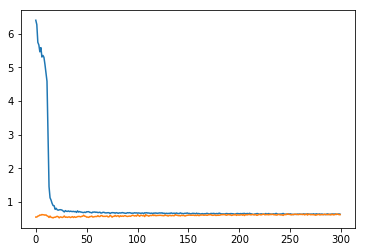

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['acc'])

In [18]:
json_string = patterns_extract.to_json()
model_json_file = open('torioux_model.json', 'w+')
model_json_file.write(json_string)
model_json_file.close()



In [19]:
patterns_extract.save_weights('torioux_w.h5')